# Distributional TD learning

- Quantileはノンパラ
- PPCやDPCはパラメトリック

Distributional Reinforcement Learning in the Brainに
> Quantile-like codes are non-parametric codes, as they do not a priori assume a specific form of a probability distribution with associated parameters. Previous studies have proposed different population coding schemes. For example, probabilistic population codes (PPCs) [73,74] and distributed distributional codes (DDCs) [75,76] employ population coding schemes from which various statistical parameters of a distribution can be read out, making them parametric codes. As a simple example, a PPC might encode a Gaussian distribution, in which case the mean would be reflected in which specific neurons are most active, and the variance would be reflected in the inverse of the overall activity [73].


([Dabney, et al., *Nature.* 2020](https://www.nature.com/articles/s41586-019-1924-6))における**Distributional Reinforcement Learning**について取り扱う．コード(MATLAB, Python)も公開されている(https://doi.org/10.17605/OSF.IO/UX5RG) ．

## Distributional TD learning

Distributional TD learningではRPEの正負に応じて，予測報酬の更新を異なる学習率($\alpha_{i}^{+}, \alpha_{i}^{-}$)を用いて行う． 

$$ 
\begin{cases} V_{i}(x) \leftarrow V_{i}(x)+\alpha_{i}^{+} f\left(\delta_{i}\right) &\text{for }
\delta_{i} \gt 0\\ V_{i}(x) \leftarrow V_{i}(x)+\alpha_{i}^{-} f\left(\delta_{i}\right) &\text{for } \delta_{i} \leq 0 \end{cases} 
$$ 

ここで，シミュレーションにおいては$\alpha_{i}^{+}, \alpha_{i}^{-}\sim U(0,
1)$とする($U$は一様分布)．さらにasymmetric scaling factor $\tau_i$を次式により定義する． 

$$ 
\tau_i=\frac{\alpha_{i}^{+}}{\alpha_{i}^{+}+ \alpha_{i}^{-}} 
$$ 

なお，$\alpha_{i}^{+}, \alpha_{i}^{-}\in [0, 1]$より$\tau_i \in
[0,1]$である． 

Classical TD learningとDistributional TD learningにおける各ニューロンのRPEに対する発火率を表現したのが次図となる．

In [1]:
using PyPlot, StatsBase
rc("axes.spines", top=false, right=false)

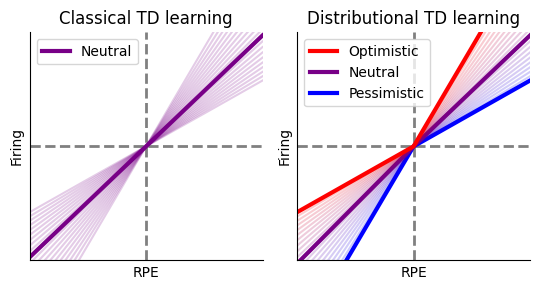

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\yamtak\.julia\packages\PyCall\3fwVL\src\numpy.jl:67


In [2]:
# Classical TD learning
N = 20
c = get_cmap("brg") 
cmap = c(range(0, 0.5, length=N))
x = range(-1, 1, step=1e-2)
θ = range(π/6, π/3, length=N)
α = tan.(θ)
y = α * x'

# Plot
figure(figsize=(5.5, 3))
subplot(1,2,1)
axvline(x=0, color="gray", linestyle="dashed", linewidth=2)
axhline(y=0, color="gray", linestyle="dashed", linewidth=2)
for i in 1:N
    if i == Int(N/2)       
        plot(x, y[i, :], color=cmap[Int(N/2), :], alpha=1, linewidth=3, label="Neutral")
    else
        plot(x, y[i, :], color=cmap[Int(N/2), :], alpha=0.2)
    end
end

ylim(-1,1); xlim(-1,1)
xticks([]); yticks([])
legend(loc="upper left")
title("Classical TD learning")
xlabel("RPE")
ylabel("Firing")

# Distributional TD learning
α_pos = tan.(θ)
α_neg = reverse!(tan.(θ))
 
yd = (α_pos * ((x .> 0) .* x)' + (α_neg) * ((x .≤ 0) .* x)') 

# Plot
ax = subplot(1,2,2)
axvline(x=0, color="gray", linestyle="dashed", linewidth=2)
axhline(y=0, color="gray", linestyle="dashed", linewidth=2)
for i in 1:N
    if i == 1        
        plot(x, yd[i, :], color=cmap[i, :], alpha=1, linewidth=3,
                 label="Pessimistic")
    elseif i == Int(N/2)       
        plot(x, yd[i, :], color=cmap[i, :], alpha=1, linewidth=3,
                 label="Neutral")
    elseif i == N
        plot(x, yd[i, :], color=cmap[i, :], alpha=1, linewidth=3,
                 label="Optimistic")
    else
        plot(x, yd[i, :], color=cmap[i, :], alpha=0.2)
    end
end
handles, labels = ax.get_legend_handles_labels()
ax.legend(reverse!(handles), reverse!(labels), loc="upper left")
ylim(-1,1); xlim(-1,1); xticks([]); yticks([])
title("Distributional TD learning"); xlabel("RPE"); ylabel("Firing")
tight_layout()

Classical TD learningではRPEに比例して発火する細胞しかないが，Distributional TD learningではRPEの正負に応じて発火率応答が変化していることがわかる． 特に$\alpha_{i}^{+} \gt \alpha_{i}^{-}$の細胞を**楽観的細胞 (optimistic cells)**，$\alpha_{i}^{+}\lt
\alpha_{i}^{-}$の細胞を**悲観的細胞 (pessimistic
cells)** と著者らは呼んでいる．実際には2群に分かれているわけではなく，gradientに遷移している．楽観的・悲観的の意味に関しては後でも触れるが，ここではイメージだけお伝えしておこう．まず楽観的細胞ではRPEが正なら「結構もらえる」，RPEが負なら「まあそういうときもある」となり最終的な予測価値は通常よりも高くなる．逆に悲観的細胞ではRPEが正なら「もらえたけどいつもそうではない…」，RPEが負なら「やっぱあんまりもらえないよね」となり最終的な予測価値は通常よりも低くなる．収束する予測価値が細胞ごとに異なることで，$V$には報酬の期待値ではなく複雑な形状の報酬分布が符号化される．その仕組みについて，次項から見ていこう．

## 12.2.2 分位数(Quantile)モデルと報酬分布の符号化

### RPEに対する応答がsign関数のモデルと報酬分布の分位点への予測価値の収束
さて，Distributional RLモデルでどのようにして報酬分布が学習されるかについてみていこう．この項ではRPEに対する応答関数$f(\cdot)$が符合関数(sign function)の場合を考える．結論から言うと，この場合はasymmetric scaling factor $\tau_i$は分位数(quantile)となり，**予測価値
$V_i$は報酬分布の$\tau_i$分位数に収束する**．
    
どういうことかを簡単なシミュレーションで見てみよう．今，報酬分布を平均2, 標準偏差5の正規分布とする (すなわち$r \sim N(2, 5^2)$となります)．また，$\tau_i = 0.25, 0.5, 0.75 (i=1,2,3)$とする．このとき，3つの予測価値 $V_i \ (i=1,2,3)$はそれぞれ$N(2, 5^2)$の0.25, 0.5,
0.75分位数に収束する．下図はシミュレーションの結果である．左が$V_i$の変化で，右が報酬分布と0.25, 0.5, 0.75分位数の位置 (黒短線)となっています．対応する分位数に見事に収束していることが分かる．

In [117]:
# init 
response_func(r) = sign(r) # RPEの応答関数
 
num_cells = 3 # ニューロン(ユニット)の数
num_steps = 5000 # 訓練回数
base_lr = 0.02 # ベースラインの学習率(learning rate)
 
μreward = 5 # 報酬の平均(正規分布)
σreward = 2 # 報酬の標準偏差(正規分布)
 
distribution = zeros(num_cells) # 価値分布を記録する配列
dist_trans = zeros(num_steps, num_cells) # 価値分布を記録する配列
 
α₊, α₋ = [0.1, 0.2, 0.3], [0.3, 0.2, 0.1] # RPEが正, 負のときの学習率
τ = α₊ ./ (α₊ + α₋); # Asymmetric scaling factor

In [4]:
# simulation
for step in 1:num_steps # 25000 steps
    # 報酬がrandomに選ばれる
    reward = μreward + randn()*σreward
     
    # 報酬誤差(step毎に更新) reward応答をlinearとする
    δ = reward .- distribution # (3, )
 
    # δが負なら1, 正なら0
    valence = δ .≤ 0 # (3, )
 
    # 予測価値分布の更新
    α = valence .* α₋ + (1. .- valence) .* α₊
    distribution += α .* response_func.(δ) .* base_lr
    dist_trans[step, :] = distribution # 予測価値分布変化の記録
end

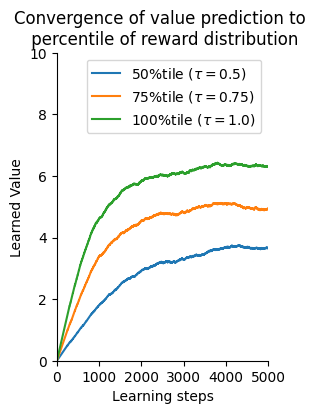

PyObject <matplotlib.legend.Legend object at 0x0000000000EA9FD0>

In [5]:
# Results plot
steps = 1:num_steps
figure(figsize=(6,4))
subplot(1,2,1) # 予測価値の変化

for i in 1:num_cells   
    plot(steps, dist_trans[:, i], label=(string((i+1)*25)*"%tile ("*L"$\tau=$"*string((i+1)*0.25)*")"))
end

title("Convergence of value prediction to \n percentile of reward distribution")
xlim(0, num_steps)
ylim(0, 10)
xlabel("Learning steps")
ylabel("Learned Value")
legend()

In [114]:
# Gaussian kernel density estimation
function kde(data, dx=0.1, band_width=1)
    x = minimum(data):dx:maximum(data)
    y = zero(x)
    n = size(data)[1]
    for i in 1:n
        y += exp.(-(((x .- data[i])/band_width).^2)/2)
    end
    y /= (n*band_width*sqrt(2π))
    return x, y
end

kde (generic function with 4 methods)

In [115]:
# 報酬のサンプリング
rewards = μreward .+ randn(2000) * σreward
qtile = nquantile(rewards, 3); # 報酬の四分位数を取得
x, y = kde(rewards);

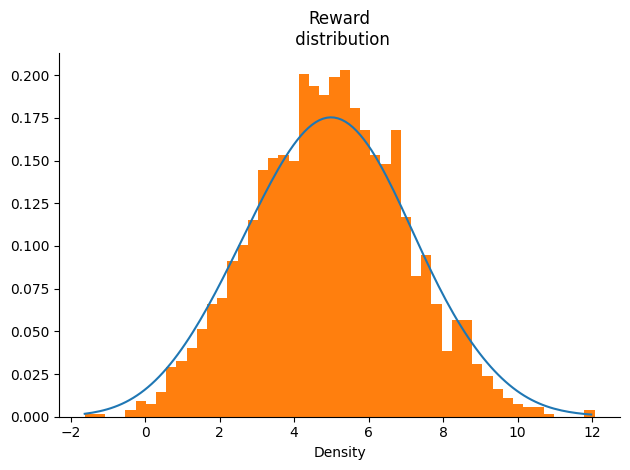

In [123]:
plot(x, y)
hist(rewards, density=true, bins=50, orientation="vertical")
title("Reward\n distribution")
xlabel("Density")
tight_layout()

ここでoptimisticな細胞($\tau=0.75$)は中央値よりも高い予測価値，pessimisticな細胞($\tau=0.25$)は中央値よりも低い予測価値に収束しています． つまり細胞の楽観度というものは，細胞が期待する報酬が大きいほど上がります．

同様のシミュレーションを今度は200個の細胞 (ユニット)で行います．報酬は0.1, 1, 2 μLのジュースがそれぞれ確率0.3, 0.6, 0.1で出るとします (Extended Data Fig.1と同じような分布にしています)．なお，著者らはシミュレーションとマウスに対して<b>Variable-magnitude task</b>
(異なる量の報酬(ジュース)が異なる確率で出る)と<b>Variable-probability task</b> (一定量の報酬がある確率で出る)を行っています．以下はVariable-magnitude taskを行う，ということです．学習結果は次図のようになります．左はGround Truthの報酬分布で，右は$V_i$に対してカーネル密度推定
(KDE)することによって得た予測価値分布です．2つの分布はほぼ一致していることが分かります．

In [120]:
response_func(r) = sign.(r) # RPEの応答関数
 
juice_amounts = [0.1, 1, 2] # reward(ジュース)の量(uL)
juice_probs = [0.3, 0.6, 0.1] # 各ジュースが出る確率

num_cells = 200 # ニューロン(ユニット)の数
num_steps = 25000 # 訓練回数
base_lrate = 0.02 # ベースラインの学習率
   
distribution = zeros(num_cells) # 価値分布を記録する配列

α₊, α₋ = rand(num_cells), rand(num_cells) # RPEが正, 負のときの学習率
τ = α₊ ./ (α₊ + α₋); # Asymmetric scaling factor

200-element Vector{Float64}:
 0.25440420500745925
 0.7852155812139469
 0.6594394473977122
 0.3484773745277892
 0.08171035938443488
 0.5675062802659787
 0.4933286867244028
 0.4579509059770634
 0.836422443639698
 0.17634813815403
 0.611315137425349
 0.36208217053384356
 0.32466122213479776
 ⋮
 0.2284948827523684
 0.4977506608152836
 0.42995559263235394
 0.9324188446113607
 0.4958919089249423
 0.640575252891557
 0.2323518916624266
 0.7174430117353767
 0.22481036149758837
 0.9113207308685322
 0.6930908334057383
 0.22325509627759538

In [150]:
for step in 1:num_steps # 25000 steps
    # 報酬がrandomに選ばれる
    reward = sample(juice_amounts, pweights(juice_probs), 1) #(1, ) StatsBase.jl参照
     
    # 報酬誤差(step毎に更新) reward応答をlinearとする
    δ = reward .- distribution # (200, )
 
    # deltaが負なら1, 正なら0
    valence = δ .≤ 0 # (200, )
 
    # 予測価値分布の更新
    α = valence .* α₋ + (1. .- valence) .* α₊
    distribution += α .* response_func.(δ) * base_lrate
end

In [151]:
# τの大きさでソートする
idx = sortperm(τ)
τ = τ[idx]
α₊ = α₊[idx]
α₋ = α₋[idx]
distribution = distribution[idx];

200-element Vector{Float64}:
 0.09501049742703858
 0.09218325100436639
 0.09681031483727352
 0.0914594596775125
 0.09769024764689965
 0.10223071428183231
 0.10182241041022282
 0.10419987711702916
 0.10416524973426801
 0.09919498777141457
 0.09397998112467998
 0.1001769073451679
 0.10380400898982714
 ⋮
 1.551295237261347
 1.9821735133786753
 1.97203898774334
 1.9979014381603757
 1.9977378061741913
 2.0081984176457675
 2.0001241279730646
 1.9999422174396626
 2.0135340538273767
 2.00546972205919
 2.009774967067564
 2.0007043189567537

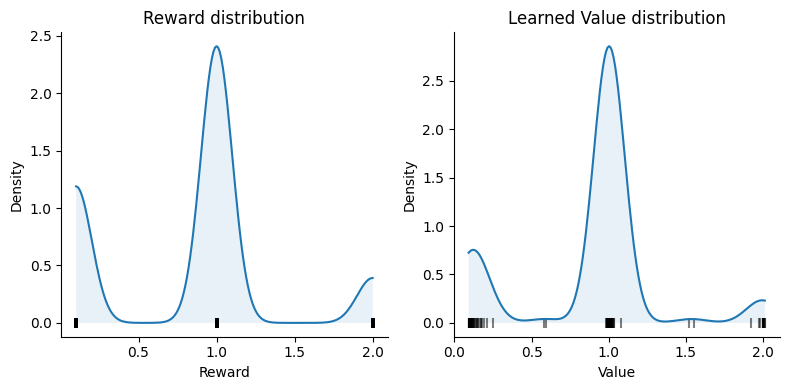

In [181]:
# 報酬をサンプリング
rewards = sample(juice_amounts, pweights(juice_probs), 1000)
 
# 結果の描画(価値・報酬分布)
figure(figsize=(8,4))
subplot(1,2,1) # Ground Truth (Reward分布)
title("Reward distribution")
x, y = kde(rewards, 0.01, 0.1);
plot(x,y); fill_between(x, y, zero(x), alpha=0.1)
scatter(rewards, zero(rewards), s=50, marker="|", color="k", alpha=0.5)
xlabel("Reward")
ylabel("Density")
 
subplot(1,2,2) # 学習後のValue(Reward)の分布
title("Learned Value distribution")
x, y = kde(distribution, 0.01, 0.1);
plot(x,y); fill_between(x, y, zero(x), alpha=0.1)
scatter(distribution, zero(distribution), s=50, marker="|", color="k", alpha=0.5) # rugplot
xlabel("Value")
ylabel("Density")
tight_layout()

そして$V_i$の経験累積分布関数(CDF)は$r$のサンプリングしたCDFとほぼ同一となっています (下図左)．また，$\tau_i$の関数である$V_i$は<b>分位点関数 (quantile function)</b>または累積分布関数の逆関数 (inverse cumulative distribution function)となっています
(下図右)．右の図を転置すると左の青い曲線とだいたい一致しそうなことが分かります．

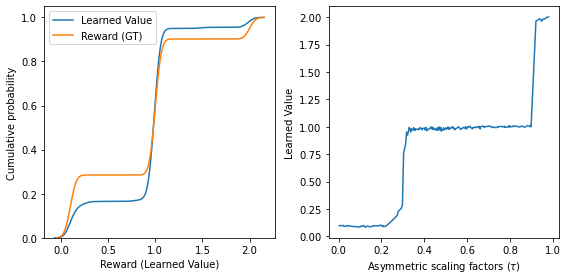

In [4]:
# 結果の描画(累積分布)
figure(figsize=(8,4))
subplot(1,2,1) # 累積分布
sns.kdeplot(distribution, cumulative=True,bw=.05, label="Learned Value")
sns.kdeplot(rewards, cumulative=True, bw=.05, label="Reward (GT)")
xlabel("Reward (Learned Value)")
ylabel("Cumulative probability")
 
subplot(1,2,2) # 累積分布
plot(tau, distribution)
xlabel("Asymmetric scaling factors ("+ r"$\tau$)")
ylabel("Learned Value")
tight_layout()
show()

### sign関数を用いたDistributional RLと分位点回帰

それでは，なぜ予測価値 $V_i$は$\tau_i$ 分位点に収束するのでしょうか．Extended Data Fig.1のように平衡点で考えてもよいのですが，後のために分位点回帰との関連について説明します．分位点回帰については記事を書いたので先にそちらを読んでもらうと分かりやすいと思います (→[Pythonによる分位点回帰 (Quantile regression)](https://salad-bowl-of-knowledge.github.io/hp/statistics/2020/01/21/quantile_regression.html))．

実はDistributional RL (かつ，RPEの応答関数にsign関数を用いた場合)における予測報酬 $V_i$の更新式は，分位点回帰(Quantile
regression)を勾配法で行うときの更新式とほとんど同じです．分位点回帰では$\delta$の関数$\rho_{\tau}(\delta)$を次のように定義します． $$ \rho_{\tau}(\delta)=\left|\tau-\mathbb{I}_{\delta \leq 0}\right|\cdot |\delta|=\left(\tau-\mathbb{I}_{\delta
\leq 0}\right)\cdot \delta $$ そして，この関数を最小化することで回帰を行います．ここで$\tau$は分位点です．また$\delta=r-V$としておきます．今回，どんな行動をしても未来の報酬に影響はないので$\gamma=0$としています．<br/>
<br/>
ここで， $$ \frac{\partial \rho_{\tau}(\delta)}{\partial \delta}=\rho_{\tau}^{\prime}(\delta)=\left|\tau-\mathbb{I}_{\delta \leq 0}\right| \cdot \operatorname{sign}(\delta) $$ なので，$r$を観測値とすると， $$
\frac{\partial \rho_{\tau}(\delta)}{\partial V}=\frac{\partial \rho_{\tau}(\delta)}{\partial \delta}\frac{\partial \delta(V)}{\partial V}=-\left|\tau-\mathbb{I}_{\delta \leq 0}\right| \cdot
\operatorname{sign}(\delta) $$ となります．ゆえに$V$の更新式は $$ V \leftarrow V - \beta\cdot\frac{\partial \rho_{\tau}(\delta)}{\partial V}=V+\beta \left|\tau-\mathbb{I}_{\delta \leq 0}\right| \cdot
\operatorname{sign}(\delta) $$ です．ただし，$\beta$はベースラインの学習率です．個々の$V_i$について考え，符号で場合分けをすると
$$ \begin{cases} V_{i} \leftarrow V_{i}+\beta\cdot |\tau_i|\cdot\operatorname{sign}\left(\delta_{i}\right)
&\text { for } \delta_{i}>0\\ V_{i} \leftarrow V_{i}+\beta\cdot |\tau_i-1|\cdot\operatorname{sign}\left(\delta_{i}\right) &\text { for } \delta_{i} \leq 0 \end{cases} $$ となります．$0 \leq
\tau_i \leq 1$であり，$\tau_i=\alpha_{i}^{+} / \left(\alpha_{i}^{+} + \alpha_{i}^{-}\right)$であることに注意すると上式は次のように書けます． $$ \begin{cases} V_{i} \leftarrow V_{i}+\beta\cdot
\frac{\alpha_{i}^{+}}{\alpha_{i}^{+}+\alpha_{i}^{-}}\cdot\operatorname{sign}\left(\delta_{i}\right) &\text { for } \delta_{i}>0\\ V_{i} \leftarrow V_{i}+\beta\cdot
\frac{\alpha_{i}^{-}}{\alpha_{i}^{+}+\alpha_{i}^{-}}\cdot\operatorname{sign}\left(\delta_{i}\right) &\text { for } \delta_{i} \leq 0 \end{cases} $$ これは前節で述べたDistributional
RLの更新式とほぼ同じです．いくつか違う点もありますが，RPEが正の場合と負の場合に更新される値の比は同じとなっています．

このようにRPEの応答関数にsign関数を用いた場合，報酬分布を上手く符号化することができます．しかし実際のドパミンニューロンはsign関数のような生理的に妥当でない応答はせず，RPEの大きさに応じた活動をします．そこで次節ではRPEの応答関数を線形にしたときの話をします．

## 12.2.3 Expectile モデルとドパミンニューロンからの報酬分布のDecoding

### RPEに対する応答が線形なモデルとExpectile回帰
節の最後で述べたようにドパミンニューロンの活動はsign関数ではなく線形な応答をする，とした方が生理学的に妥当である (発火率を表現するならば$f(\delta)=c+\delta\quad(c > 0)$とした方が良いだろうが)．それでは予測価値の更新式を 

$$ 
\begin{cases} V_{i}(x) \leftarrow V_{i}(x)+\alpha_{i}^{+}
\delta_{i} &\text{for } \delta_{i} \gt 0\\ V_{i}(x) \leftarrow V_{i}(x)+\alpha_{i}^{-} \delta_{i} &\text{for } \delta_{i} \leq 0 \end{cases} 
$$

とした場合は，分位点回帰ではなく何に対応するのだろうか．結論から言えば，この場合は **エクスペクタイル回帰(Expectile
regression)** と同じになる．expectileという用語自体はexpectationとquantileを合わせたような概念，というところから来ている．**中央値(median)に対する分位数(quantile)が，平均(mean)あるいは期待値(expectation)に対するexpectileの関係と同じ** であると捉えると良いです．
もう少し言えば，前者は誤差のL1ノルム, 後者はL2ノルムの損失関数を最小化することにより得られる (cf. [Quantile and Expectile Regressions](https://freakonometrics.hypotheses.org/files/2017/05/erasmus-1.pdf))．

分位点回帰で用いた損失関数は

$$
\rho_{\tau}(\delta)=\left|\tau-\mathbb{I}_{\delta \leq 0}\right|\cdot |\delta|
$$

だったが，最後の$|\delta|$を$\delta^2$として， 

$$
\rho^E_{\tau}(\delta)=\left|\tau-\mathbb{I}_{\delta \leq
0}\right|\cdot \delta^2
$$

とする．これを微分すれば 

$$ 
\frac{\partial \rho^E_{\tau}(\delta)}{\partial \delta}=\rho_{\tau}^{E\prime}(\delta)=2 \cdot \left|\tau-\mathbb{I}_{\delta \leq 0}\right| \cdot \delta 
$$

となり，上記の予測価値の更新式がExpectile回帰の損失関数から導けることが分かる．

### 報酬分布のデコーディング (decoding)
それで，RPEの応答を線形とした場合は報酬分布を上手く学習できるのかという話ですが，実はRPEの応答をsign関数とした場合と同じように学習後の予測価値の分布を求めても報酬分布は復元されません (簡単な修正で確認できます)．そこで報酬分布をデコーディングする方法を考えます．

デコーデイングには各細胞が学習した予測価値(またはreversal points) $V_i$, asymmetries $\tau_i$, および報酬分布(ただし報酬の下限と上限からの一様分布)からのサンプル $z_m (m=1,2,\cdots,
M)$を用います．$N$を推定する$V_i$の数，$M=100$を1つの報酬サンプル集合$\{z_m\}$内の要素数としたとき，次の損失関数を最小にする集合$\{z_m\}$を求めます． $$ \mathcal{L}(z, V, \tau)=\frac{1}{M} \sum_{m-1}^{M} \sum_{n=1}^{N}\left|\tau_{n}-\mathbb{I}_{z_{m} \leq
V_{n}}\right|\left(z_{m}-V_{n}\right)^{2} $$ ここで，集合$\{z_m\}$は20000回サンプリングするとします．損失関数$\mathcal{L}$を最小化する集合の分布が推定された報酬分布となっているので，それをplotします．以下はその結果とコードです
(このコードはほとんど著者実装のままです)．灰色が元の報酬分布で，紫がデコーデイングされた分布です．完全とはいきませんが，ある程度は推定できていることが分かります．

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:33<00:00,  6.69s/it]


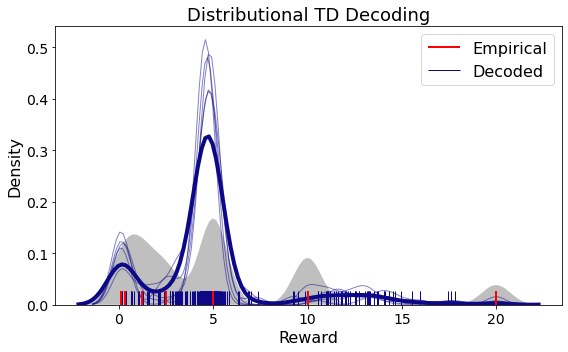

In [5]:
#collapse-hide

import scipy.stats
import scipy.optimize
 
def expectile_loss_fn(expectiles, taus, samples):
  """Expectile loss function, corresponds to distributional TD model """
  # distributional TD model: delta_t = (r + \gamma V*) - V_i
  # expectile loss: delta = sample - expectile
  delta = (samples[None, :] - expectiles[:, None])
 
  # distributional TD model: alpha^+ delta if delta > 0, alpha^- delta otherwise
  # expectile loss: |taus - I_{delta <= 0}| * delta^2
 
  # Note: When used to decode we take the gradient of this loss,
  # and then evaluate the mean-squared gradient. That is because *samples* must
  # trade-off errors with all expectiles to zero out the gradient of the 
  # expectile loss.
  indic = np.array(delta <= 0., dtype=np.float32)
  grad = -0.5 * np.abs(taus[:, None] - indic) * delta
  return np.mean(np.square(np.mean(grad, axis=-1)))
 
def run_decoding(reversal_points, taus, minv=0., maxv=1., method=None,
                 max_samples=1000, max_epochs=10, M=100):
  """Run decoding given reversal points and asymmetries (taus)."""
   
  # sort
  ind = list(np.argsort(reversal_points))
  points = reversal_points[ind]
  tau = taus[ind]
 
  # Robustified optimization to infer distribution
  # Generate max_epochs sets of samples,
  # each starting the optimization at the best of max_samples initial points.
  sampled_dist = []
  for _ in range(max_epochs):
      # Randomly search for good initial conditions
      # This significantly improves the minima found
      samples = np.random.uniform(minv, maxv, size=(max_samples, M))
      fvalues = np.array([expectile_loss_fn(points, tau, x0) for x0 in samples])
 
      # Perform loss minimizing on expectile loss (w.r.t samples)
      x0 = np.array(sorted(samples[fvalues.argmin()]))
      fn_to_minimize = lambda x: expectile_loss_fn(points, tau, x)
      result = scipy.optimize.minimize(
              fn_to_minimize, method=method,
              bounds=[(minv, maxv) for _ in x0], x0=x0)["x"]
      sampled_dist.extend(result.tolist())
 
  return sampled_dist, expectile_loss_fn(points, tau, np.array(sampled_dist))
 
 
# reward distribution
juice_amounts = np.array([0.1, 0.3, 1.2, 2.5, 5, 10, 20])
juice_empirical_probs = np.array(
    [0.06612594, 0.09090909, 0.14847358, 0.15489467,
     0.31159175, 0.1509519 , 0.07705306])
 
# samples of reward (1000, )
sampled_empirical_dist = np.random.choice(
    juice_amounts, p=juice_empirical_probs, size=1000)
 
n_trials = 10 # num of simulation trial
n_epochs = 20000 # num of simulation epoch
num_cells = 151  # num of cells or units
n_decodings = 5 # num of decodings
 
# Global scale for learning rates
beta = 0.2
 
# Distributional TD simulation and decoding
distribution = np.zeros((n_trials, num_cells))
alpha_pos = np.random.random((num_cells))*beta
alpha_neg = np.random.random((num_cells))*beta 
# alpha_neg = beta - alpha_pos としてもよい
 
# Simulation
for trial in tqdm(range(n_trials)):
    for step in range(n_epochs):
        # Sample reward
        reward = np.random.choice(juice_amounts, p=juice_empirical_probs)
        # Compute TD error
        delta = reward - distribution[trial]
        # Update distributional value estimate
        valence = np.array(delta <= 0., dtype=np.float32)
        alpha = valence * alpha_neg + (1. - valence) * alpha_pos
        distribution[trial] += alpha * delta
 
# Decoding from distributional TD (DTD) simulation
dtd_samples = [] # 
dtd_losses = [] # decoding loss
taus = alpha_pos / (alpha_pos + alpha_neg)
 
asym_variance = 0.2
 
for t in tqdm(range(n_decodings)):
    # Add noise to the scaling, but have mean 0.5 giving symmetric updates
    scaling_noise = np.tanh(np.random.normal(size=len(taus))) * asym_variance
    noisy_tau = np.clip(taus + scaling_noise, 0., 1.) # add noise
 
    # Run decoding for distributional TD
    values = run_decoding(
      distribution.mean(0), noisy_tau, 
      minv=juice_amounts.min(), maxv=juice_amounts.max(),
      max_epochs=1, M=100, max_samples=20000, method="TNC")
 
    dtd_samples.append(values[0])
    dtd_losses.append(values[1])
    # print(t, values[1]) 
 
# results of decoding
dtd_reward_decode = np.array(dtd_samples).flatten()
 
# plot
fig = figure(figsize=(8, 5))
# Ground truth
sns.kdeplot(sampled_empirical_dist, bw=.75, color="k", lw=0., shade=True)
sns.rugplot(sampled_empirical_dist, color="red", lw=2, zorder=10, label="Empirical")
 
# decoded distribution
sns.kdeplot(dtd_reward_decode, bw=.75, color=cm.plasma(0), lw=4., zorder=5, shade=False)
sns.rugplot(dtd_reward_decode, color=cm.plasma(0), label="Decoded")
for draw in dtd_samples:
  sns.kdeplot(draw, bw=.5, color=cm.plasma(0.), alpha=.5, lw=1., shade=False)
 
tick_params(top=False, right=False, labelsize=14)
legend(loc="best", fontsize=16)
xlabel("Reward", fontsize=16)
ylabel("Density", fontsize=16)
title("Distributional TD Decoding", fontsize=18)
tight_layout()
show()

このようにしてRPEに対する応答が線形であるとした場合でも報酬分布を推定できました．同じことを著者らはドパミンニューロンの活動に対しても行い，報酬分布がデコーデイングされることを示しています．ただ，デコーデイングの手間が結構かかっている気がするので，学習した予測価値分布を利用するときにはどのような処理をしているのかは気になります．  

## 参考文献

- Dabney, W., Kurth-Nelson, Z., Uchida, N. *et al.* A distributional code for value in dopamine-based reinforcement learning. *Nature* (2020). [https://doi.org/10.1038/s41586-019-1924-6](https://www.nature.com/articles/s41586-019-1924-6)
- Watabe-Uchida, M. et al. Whole-Brain Mapping of Direct Inputs to Midbrain Dopamine Neurons. Neuron 74, 5, 858 - 873 (2012). [https://doi.org/10.1016/j.neuron.2012.03.017](https://www.cell.com/neuron/fulltext/S0896-6273(12)00281-4)[ ](https://www.cell.com/neuron/fulltext/S0896-6273(12)00281-4)
- Eshel, N., Tian, J., Bukwich, M. *et al.* Dopamine neurons share common response function for reward prediction error. *Nat Neurosci* **19,** 479–486 (2016). [https://doi.org/10.1038/nn.4239](https://www.nature.com/articles/nn.4239)
- Schultz, W., Dayan, P., Montague, P.R. A neural substrate of prediction and reward. *Science*. 275, 1593-9 (1997). [doi:10.1126/science.275.5306.1593](https://science.sciencemag.org/content/275/5306/1593.long)
- Chang, C., Esber, G., Marrero-Garcia, Y. *et al.* Brief optogenetic inhibition of dopamine neurons mimics endogenous negative reward prediction errors. *Nat Neurosci* **19,** 111–116 (2016) [doi:10.1038/nn.4191](https://www.nature.com/articles/nn.4191)  
- Bayer, H.M., Lau, B., Glimcher, P.W. Statistics of midbrain dopamine neuron spike trains in the awake primate. *J Neurophysiol*. **98**(3):1428-39 (2007). [https://doi.org/10.1152/jn.01140.2006](https://www.physiology.org/doi/full/10.1152/jn.01140.2006)
- Eshel, N., Bukwich, M., Rao, V. *et al.* Arithmetic and local circuitry underlying dopamine prediction errors. *Nature* **525,** 243–246 (2015). [https://doi.org/10.1038/nature14855](https://www.nature.com/articles/nature14855)